In [3]:
import numpy as np
from numpy.random import rand
from scipy.linalg import ishermitian
from numpy import kron
import stim
from copy import copy
import time
import itertools

## One Qubit tomography in Stim

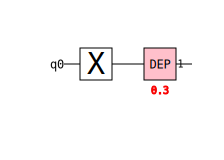

In [10]:
# Sample circuit for Quantum state tomography
one = stim.Circuit()
one.append_operation("X", 0)
one.append_operation("DEPOLARIZE1", 0, 0.3)
one.diagram(type="timeline-svg")

In [11]:
# Hardcoding more or less with optimization technique from https://arxiv.org/abs/1106.5458
def one_qubit_tomography(circuit, num_samples):
    measurements = ["MX", "MY", "MZ"]
    meas_circs = []
    for m in measurements:
        cop = copy(circuit)
        cop.append_operation(m, 0)
        meas_circs.append(cop)
    
    pm = {True: -1, False: 1} # Is this correct?
    r_vals = []
    
    # run circuits
    for c in meas_circs:
        ave = 0.0
        for i in range(num_samples):
            simulator = stim.TableauSimulator()
            simulator.do(c)
            results = simulator.current_measurement_record()
            meas = pm[results[0]]
            ave += meas
        ave = ave / num_samples
        r_vals.append(ave)
        
    print(r_vals) #debug
    print("\n")
    
    X = np.array([[0, 1],[1,0]])
    Y = np.array([[0, -1j],[1j, 0]])
    Z = np.array([[1, 0],[0,-1]])
    I = np.array([[1,0],[0,1]])
    mu = 1/2*(I + r_vals[0]*X + r_vals[1]*Y + r_vals[2]*Z)
    
    print(mu) # debug
    print("\n")
    
    # calculate eigenvalues of µ matrix
    eigen = np.linalg.eig(mu)
    vals  = eigen[0]
    vecs  = eigen[1].transpose()

    # order eigenvalues from largest to smallest
    eig_vals = sorted(vals, reverse=True)
    idx      = []
    for val in eig_vals:
        idx.append(np.where(vals == val)[0][0])
    eig_vecs = []
    for i in idx:
        eig_vecs.append(vecs[i])
        
    # calculate eigenvalues of the density matrix
    accumulator = 0
    lamb_vals   = [None] * len(eig_vals)
    for i in range(len(eig_vals) - 1, -1, -1):
        if eig_vals[i] + (accumulator / (i + 1)) >= 0:
            for j in range(i + 1):
                lamb_vals[j] = eig_vals[j] +  (accumulator / (i + 1))
            break
        else:
            lamb_vals[i] = 0
            accumulator  += eig_vals[i]

    # calculate density matrix
    predicted_state = lamb_vals[0] * np.outer(eig_vecs[0], eig_vecs[0].conj()) \
                        + lamb_vals[1] * np.outer(eig_vecs[1], eig_vecs[1].conj())
    
#     # calculate fidelity
#     fidelity = input_state.conj().dot(predicted_state).dot(input_state)
    
    return predicted_state

# Optimization really doesn't seem to be helping in 1 qubit case huh.
rho = one_qubit_tomography(one, num_samples=int(1e4))
print(rho)

[-0.012, -0.0048, -0.6022]


[[ 0.1989+0.j     -0.006 +0.0024j]
 [-0.006 -0.0024j  0.8011+0.j    ]]


[[ 0.1989+0.j     -0.006 +0.0024j]
 [-0.006 -0.0024j  0.8011+0.j    ]]


# Two Qubit Tomography in Stim:

See [link](https://github.com/epelaaez/QuantumLibrary/blob/master/challenges/QOSF%20Monthly/July%202021.ipynb) for reference.

Methodology
1. Get the 3^n required measurement bases by enumerating elements of the cartesian product {X, Y, Z}^2.
2. For one instance of the circuit, append corresponding measurements and sample N times (Will this require regenerating circuits? For now, assume not, but see what Simon thinks
3. Calculate the expectation values for each pauli string
4. Reconstitute the density matrix
5. (Optional) Optimize using the techniques from Smolin's "Maximum Likelihood, Minimum Effort" paper

In [4]:
"""
Enumerate all strings in arr (kept as a free parameter because we'll need to enumerate both ['X', 'Y', 'Z'] 
and ['I', 'X', 'Y', 'Z'])

n = number of qubits
"""
def measurements_strings(n, arr = ['X', 'Y', 'Z']):
    strs = [p for p in itertools.product(arr, repeat=n)]
    return strs

bases = measurements_strings(2, arr = ["MX", "MY", "MZ"])
print(bases)

[('MX', 'MX'), ('MX', 'MY'), ('MX', 'MZ'), ('MY', 'MX'), ('MY', 'MY'), ('MY', 'MZ'), ('MZ', 'MX'), ('MZ', 'MY'), ('MZ', 'MZ')]


In [6]:
"""
Add measurements to a stim circuit
"""
def add_measurements(circuit, teleported_pair, bases):
    measured_circuits = []
    for b in bases:
        c = stim.Circuit()
        c.append(b[0], teleported_pair[0])
        c.append(b[1], teleported_pair[1])
        measured_circuits.append(c)
    return measured_circuits

In [7]:
def sample_circuits(simulator, measured_circuits, debug=False):
    for idx, c in enumerate(measured_circuits):
        if debug: print(f"Running circuit {idx}")
        sim_copy = simulator.copy()
        sim_copy.do(c)
        results = simulator.current_measurement_record()
        print(results[-2], results[-1])

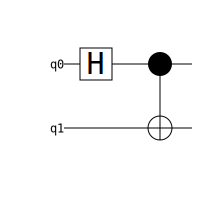

In [20]:
# Sample circuit for Quantum state tomography
bell = stim.Circuit()
bell.append_operation("H", 0)
bell.append_operation("CNOT", [0, 1])
bell.diagram(type="timeline-svg")

In [ ]:
# two qubit state tomography:
# do hardcoding first, improve later
def two_qubit_tomography(circuit, num_samples=100, debug=True):
    pauli_strings = ['II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']
    dm = []
    for s in pauli_strings:
        ave_meas = 0.0
        for i in range(num_samples):
            cop = copy(circuit)
            cop.append(f"{s[0]}", 0)
            cop.append(f"{s[1]}", 1)
            cop.append("MR", 0)
            cop.append("MR", 1)
            simulator = stim.TableauSimulator()
            simulator.do(cop)
            results = simulator.current_measurement_record()
            pm = {True: 1, False: -1}
            meas = (pm[results[0]] * pm[results[1]])
            print(results)
            print(meas)
            time.sleep(0.3)
            ave_meas += meas
        print(ave_meas)
        ave_meas = ave_meas / num_samples
        dm.append(ave_meas)
    print(dm)
            
c = two_qubit_tomography(bell, num_samples=100)
# Something's not adding up for ideal case

# print(cop)
# print("")
# time.sleep(0.5)
# pause and check work

#             print(results)
#             print((pm[results[0]] + pm[results[1]])/2)
#             print()

In [ ]:
pm = {True: 1, False: -1}
pm[True]

# Sandboxing

In [1]:
import itertools

In [2]:
"""
Enumerate all strings in {X, Y, Z}^n

Credit to (Emilio Peláez)
https://github.com/epelaaez/QuantumLibrary/blob/master/challenges/QOSF%20Monthly/July%202021.ipynb

n = number of qubits
arr = array of non-identity pauli operators
"""
def measurements_strings(n, arr=['X', 'Y', 'Z']):
    strs  = []
    combs = list(itertools.combinations_with_replacement(arr, n))
    for comb in combs: # Why isn't there an itertools method for permutation w replacement? Is this necessary? 
        for item in set(list(itertools.permutations(comb))):
            strs.append(item)
    return strs

print(measurements_strings(2))

[('X', 'X'), ('Y', 'X'), ('X', 'Y'), ('X', 'Z'), ('Z', 'X'), ('Y', 'Y'), ('Y', 'Z'), ('Z', 'Y'), ('Z', 'Z')]


In [9]:
"""
Enumerate all strings in {X, Y, Z}^n
n = number of qubits
"""
def measurements_strings(n):
    arr = ['X', 'Y', 'Z']
    strs = [p for p in itertools.product(arr, repeat=n)]
    return strs

def 

sts = measurements_strings(2)
print(sts)

[('X', 'X'), ('X', 'Y'), ('X', 'Z'), ('Y', 'X'), ('Y', 'Y'), ('Y', 'Z'), ('Z', 'X'), ('Z', 'Y'), ('Z', 'Z')]


In [ ]:
def get_exp_value(operator_exp, operators_meas, counts, shots):
    """
    Parameters:
        operator_exp: tuple
        operators_meas: list
        counts: list
        shots: int
    """
    new_counts = {}
    ignore = []
    
    # if the operator of the expectation value contains the identity in any qubit
    if 'I' in operator_exp: 
        rep_op = []
        for idx, x in enumerate(operator_exp):
            if x == 'I':
                ignore.append(idx)
                rep_op.append('X')
            else:
                rep_op.append(x) 
    # if there aren't any identities in the expectation operator
    else:                   
        rep_op = operator_exp
        
    # get index of operator_exp in experiment operator_meas, which is the same as in counts
    for idx, x in enumerate(operators_meas):
        if x == tuple(rep_op):
            count_idx = idx

    # create new counts dictionary
    for idx, value in counts[count_idx].items():
        w = idx[::-1]
        for i in ignore:
            w = w[:i] + 'x' + w[i + 1:]
        if w in new_counts.keys():
            new_counts[w] += value
        else:
            new_counts[w] = value
                
    # get expectation value
    exp_value = 0
    for idx, num_meas in new_counts.items():
        meas_val = 1
        for x in idx:
            if x == '1':
                meas_val *= -1
            else:
                pass        
        exp_value += meas_val * num_meas
    exp_value /= shots
        
    return exp_value

In [ ]:
def mu_optimize(mu, n):
    # calculate eigenvalues of µ matrix
    eigen = np.linalg.eig(mu)
    vals  = eigen[0]
    vecs  = eigen[1].transpose()

    # order eigenvalues from largest to smallest
    eig_vals = sorted(vals, reverse=True)
    idx      = []
    for val in eig_vals:
        idx.append(np.where(vals == val)[0][0])
    eig_vecs = []
    for i in idx:
        eig_vecs.append(vecs[i])
        
    # calculate eigenvalues of the density matrix
    accumulator = 0
    lamb_vals   = [None] * len(eig_vals)
    for i in range(len(eig_vals) - 1, -1, -1):
        if eig_vals[i] + (accumulator / (i + 1)) >= 0:
            for j in range(i + 1):
                lamb_vals[j] = eig_vals[j] +  (accumulator / (i + 1))
            break
        else:
            lamb_vals[i] = 0
            accumulator  += eig_vals[i]

    # calculate density matrix
    predicted_state = np.zeros((2 ** n, 2 ** n), 'complex')
    for idx, lamb_val in enumerate(lamb_vals):
        predicted_state += lamb_vals[idx] * np.outer(eig_vecs[idx], eig_vecs[idx].conj())
    
    return predicted_state

In [ ]:
def tomography(samples):
    """
    Performs quantum state tomography in an n-qubit state.
    
    Parameters:
        samples: int
            Number of samples available of the input state
    
    Returns:
        predicted_state: np.array
            Density matrix of state predicted via quantum state tomography
        fidelity: float
            Fidelity of predicted state in respected to input state
    """
#     # get number of qubits and bases to be measured in
#     n     = int(np.log(len(input_state)) / np.log(2))
    n = 2
    bases = measurements_strings(n)
    
    # generate 3^n circuits with each measurement operator in {X, Y, Z}^n
    circs = []
    for base in bases:
        qc = QuantumCircuit(n, n)
        qc.initialize(input_state)
        for idx, b in enumerate(base):
            if b == 'X':
                measure_x_basis(qc, idx)
            elif b == 'Y':
                measure_y_basis(qc, idx)
            elif b == 'Z':
                measure_z_basis(qc, idx)
        circs.append(qc)
    
    # run circuits
    backend = Aer.get_backend('qasm_simulator')
    job     = execute(circs, backend, shots=samples) # each measurement basis gets a third of the available copies
    counts  = job.result().get_counts()
    
    # get all expectation values
    ops      = measurements_strings(n, arr=['I', 'X', 'Y', 'Z'])[1:] # we need to consider identity operator here
    exp_vals = []
    for op in ops:
        exp_vals.append(get_exp_value(op, bases, counts, samples))

    # calculate µ matrix 
    mu = tensor_operator(['I' for _ in range(n)])
    for idx, op in enumerate(ops):
        mu += exp_vals[idx] * tensor_operator(op)
    mu /= (2 ** n)
    
    # optimize the µ matrix to get the predicted density matrix
    predicted_state = mu_optimize(mu, n)
    
    # calculate fidelity
    fidelity = input_state.conj().dot(predicted_state).dot(input_state)
    
    return predicted_state, fidelity